In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load imagenet class names for visualization usage
class_name_txt = 'imagenet1000_clsid_to_human.txt'
lines = open(class_name_txt).readlines()
class_map, inverse_class_map = {}, {}
for line in lines:
    line_split = line.strip().strip(',').strip("'").split(": '")
    class_id = int(line_split[0])
    class_name = line_split[1]
    class_map[class_id] = class_name
    inverse_class_map[class_name] = class_id

In [4]:
# Load the pretrained model
# pretrained_model = models.resnet18(pretrained=True)
pretrained_model = models.vgg11(pretrained=True)
# Set model to evaluation mode
pretrained_model.eval()
pretrained_model = pretrained_model.to(device)

In [5]:
# scaler = transforms.Scale((224, 224))
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

340 zebra


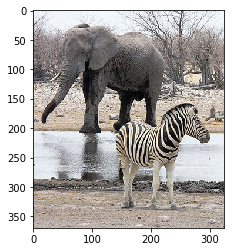

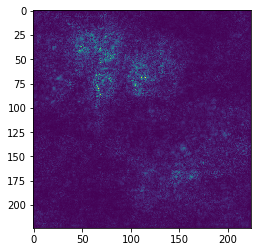

In [6]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
t_img = t_img.to(device)
t_img.requires_grad = True
output = pretrained_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.cpu().numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).cpu().numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()

In [7]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        classifiers = [
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ]
        self.layers = nn.ModuleList(features + classifiers)
        self.reshape_feature_layer_num = len(features)

    def forward(self, x):
        for i, layer in list(enumerate(self.layers)):
            if i == self.reshape_feature_layer_num:
                x = x.view(x.size(0), -1)
            x = layer(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return layers


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    """
    model = VGG(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    """
    model = VGG(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    """
    model = VGG(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_bn(**kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19(**kwargs):
    """VGG 19-layer model (configuration "E")
    """
    model = VGG(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_bn(**kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model

In [8]:
new_model = vgg11()
new_model.eval()
new_model = new_model.to(device)

In [9]:
pretrained_layers = list(pretrained_model.state_dict().items())
count=0
for key, value in new_model.state_dict().items():
    layer_name, weights = pretrained_layers[count]
    new_model.state_dict()[key].data.copy_(weights)
    count+=1

340 zebra


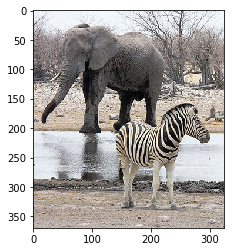

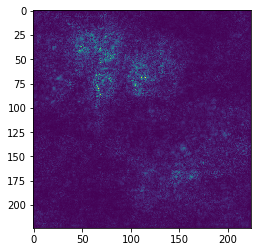

In [10]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
t_img = t_img.to(device)
t_img.requires_grad = True
output = new_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.cpu().numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).cpu().numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()